## Importing Necessary Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Base
# -----------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Hypothesis Testing
# -----------------------------------
from scipy.stats import shapiro
import scipy.stats as stats

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

## Reading the data file

In [58]:
data = pd.read_csv('/content/drive/MyDrive/ab testing project /cookie_cats.csv')


## Exploratory Data Analysis

In [59]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [ ]:
data.shape

(90189, 5)


In [ ]:
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
if not data.isnull().any().any():
    print("No missing values!")
else:
    print("There are missing values.")


No missing values!


## Summary Statistics

In [ ]:
# Number of Unique User
print("Unique Users: ", data.userid.nunique() == data.shape[0])
# Summary Stats: sum_gamerounds
data.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]]


Unique Users:  True


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


In [ ]:
# A/B Groups & Target Summary Stats
data.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


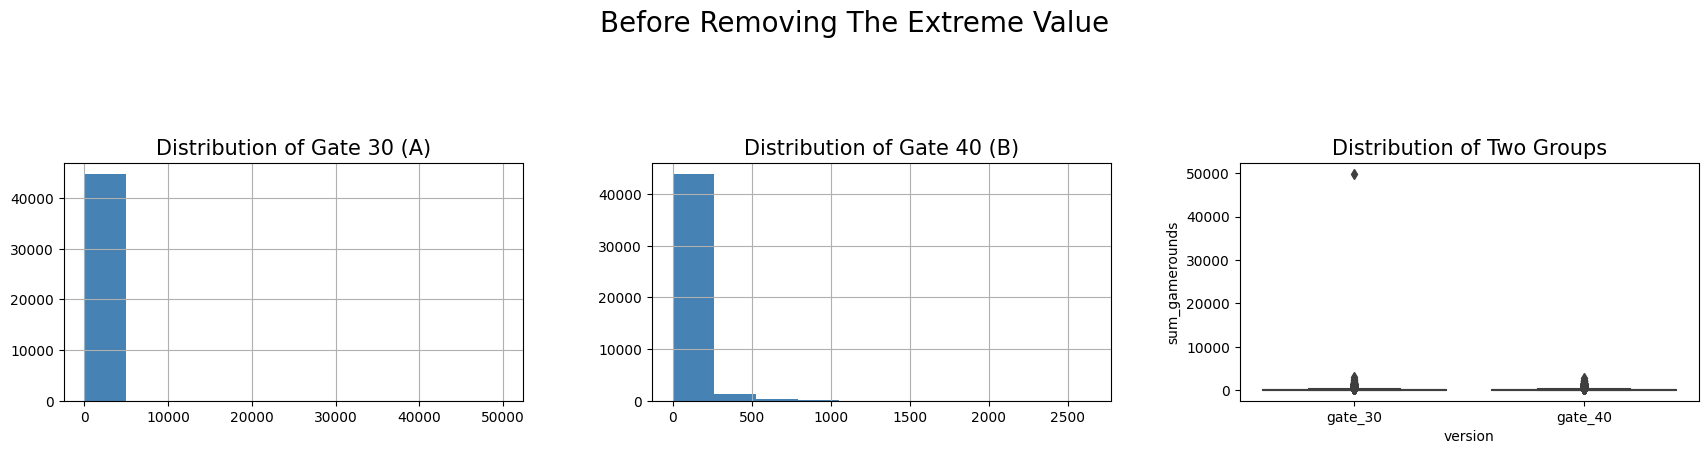

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
data[(data.version == "gate_30")].hist("sum_gamerounds", ax = axes[0], color = "steelblue")
data[(data.version == "gate_40")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
sns.boxplot(x = data.version, y = data.sum_gamerounds, ax = axes[2])

plt.suptitle("Before Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[1].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[2].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

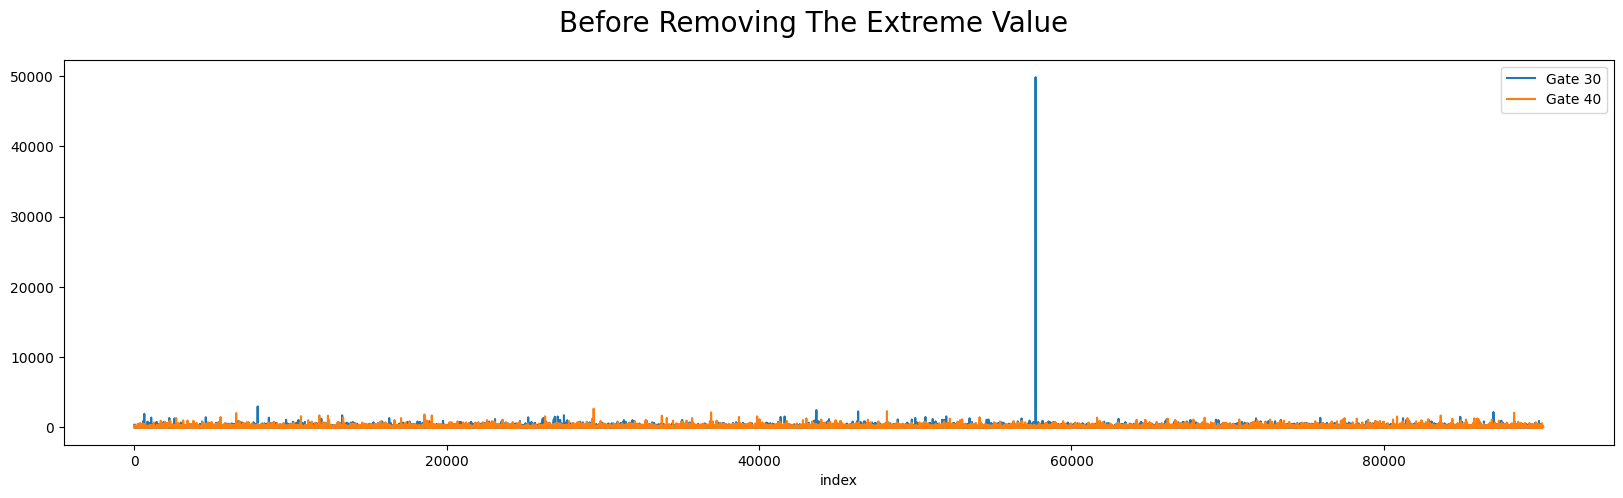

In [ ]:
data[data.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
data[data.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40")
plt.suptitle("Before Removing The Extreme Value", fontsize = 20);

## Outliers
this code removes rows from the data DataFrame where the value in the sum_gamerounds column is equal to its maximum value. Essentially, it's removing the row(s) with the highest number of gamerounds.

In [65]:
# Checking the outlier
data[data['sum_gamerounds']>40000]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


In [66]:
data = data.drop(data.loc[data['sum_gamerounds']>4000].index)


In [67]:
data = data[data.sum_gamerounds < data.sum_gamerounds.max()]
data.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]]


,sum_gamerounds
count,90187.0000
mean,51.2880
std,102.2252
min,0.0000
1%,0.0000
5%,1.0000
10%,1.0000
20%,3.0000
50%,16.0000
80%,67.0000


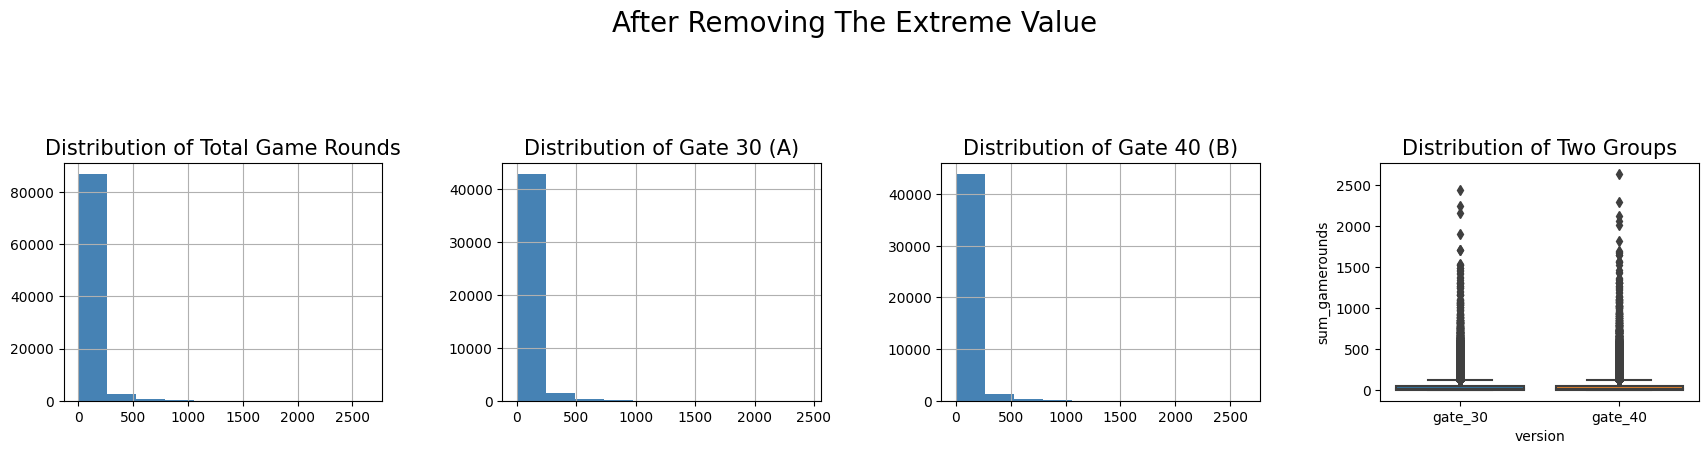

In [68]:
fig, axes = plt.subplots(1, 4, figsize = (18,5))
data.sum_gamerounds.hist(ax = axes[0], color = "steelblue")
data[(data.version == "gate_30")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
data[(data.version == "gate_40")].hist("sum_gamerounds", ax = axes[2], color = "steelblue")
sns.boxplot(x = data.version, y = data.sum_gamerounds, ax = axes[3])

plt.suptitle("After Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Total Game Rounds", fontsize = 15)
axes[1].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[2].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[3].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

overlaid on the same axes, with "Gate 30" and "Gate 40" labels, making it easy to compare trends or patterns between the two versions in the sum_gamerounds column.

<function matplotlib.pyplot.show(close=None, block=None)>

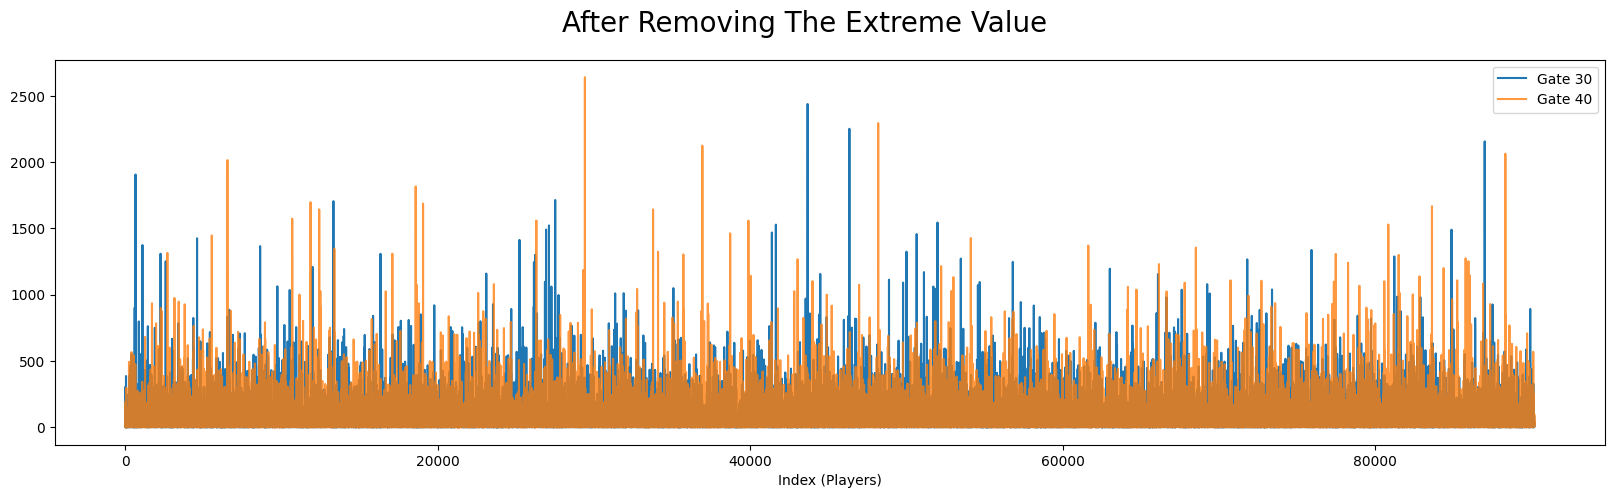

In [69]:
data[(data.version == "gate_30")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
data[data.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("After Removing The Extreme Value", fontsize = 20)
plt.xlabel('Index (Players)')
plt.show

In [30]:
data.groupby("sum_gamerounds").userid.count().reset_index().head(20)


,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


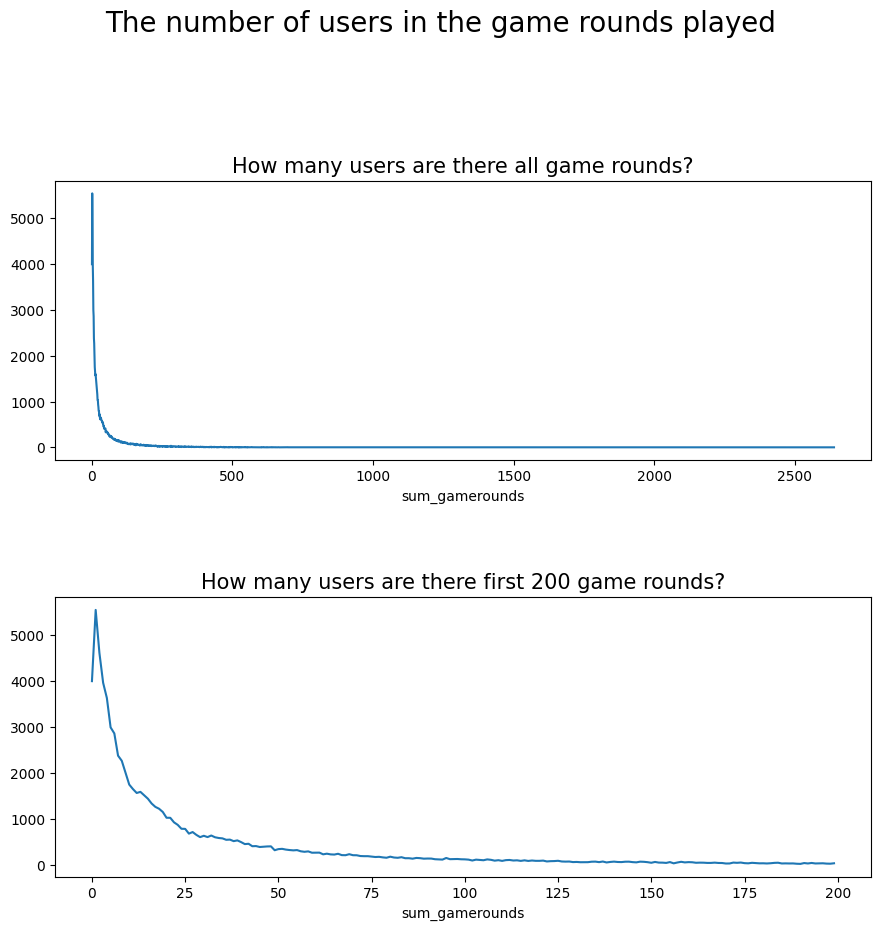

In [29]:
fig, axes = plt.subplots(2, 1, figsize = (10,10))
data.groupby("sum_gamerounds").userid.count().plot(ax = axes[0])
data.groupby("sum_gamerounds").userid.count()[:200].plot(ax = axes[1])
plt.suptitle("The number of users in the game rounds played", fontsize = 20)
axes[0].set_title("How many users are there all game rounds?", fontsize = 15)
axes[1].set_title("How many users are there first 200 game rounds?", fontsize = 15)
plt.tight_layout(pad=5);

We can see that there are 3994 players hwo downloaded the game but never played.

*   Could be that they did not have time to play the game.

*   Did not like the app or the uder interface
---

# Statistics for each version

In [70]:
# How many users reached gate 30 & gate 40 levels?
data.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

There's a bigger difference in number of players between 40 to 50 rounds compared to 30 to 40. This is could due to;


*   They loose interest in the game with progression
*   Users give up due to increase in difficulty



In [71]:
# A/B Groups & Target Summary Stats
data.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])


,count,median,mean,std,max
version,,,,,
gate_30,44698,17.0000,51.2770,101.1265,2438
gate_40,45489,16.0000,51.2988,103.2944,2640


Looking at the summary statistics, the control and Test groups seem similar, but are the two groups statistically significant?

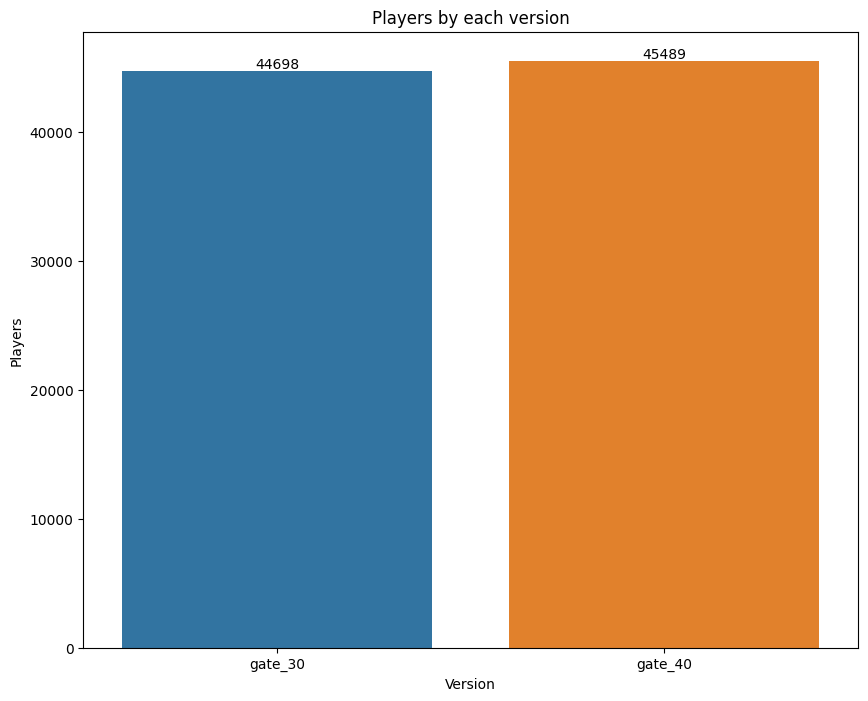

In [72]:
# Visualize the count of users by version
plt.figure(figsize=(10,8))
ax = sns.countplot(data=data, x='version')
plt.title('Players by each version')
plt.ylabel('Players')
plt.xlabel('Version')
ax.bar_label(ax.containers[0])
plt.show()

## Player Retention Statistic


*   retention_1 - did players return 1 day after installing?
*   retention_7 - did players return 7 days after installing?




In [73]:
# Retention Problem
retention = pd.DataFrame({"RET1_COUNT": data["retention_1"].value_counts(),
              "RET7_COUNT": data["retention_7"].value_counts(),
              "RET1_RATIO": data["retention_1"].value_counts() / len(data),
              "RET7_RATIO": data["retention_7"].value_counts() / len(data)})
retention.T

,False,True
RET1_COUNT,50035.0000,40152.0000
RET7_COUNT,73408.0000,16779.0000
RET1_RATIO,0.5548,0.4452
RET7_RATIO,0.8140,0.1860


Lets see if there is a statistically significant difference between retension by versions.

In [74]:
## players returning after 1 day for each version
data.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median    mean      std   max
version retention_1                                      
gate_30 False        24665  6.0000 16.3591  36.5284  1072
        True         20033 48.0000 94.2686 133.5135  2438
gate_40 False        25370  6.0000 16.3404  35.9258  1241
        True         20119 49.0000 95.3812 137.8873  2640

In [75]:
## for players returning after 7 days for each version
data.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count   median     mean      std   max
version retention_7                                        
gate_30 False        36198  11.0000  25.7965  43.3162   981
        True          8500 105.0000 159.7880 176.7771  2438
gate_40 False        37210  11.0000  25.8564  44.4061  2640
        True          8279 111.0000 165.6498 183.7925  2294

In [76]:
## players who returned after 1 day and also 7 days of installing the game
data["Retention"] = np.where((data.retention_1 == True) & (data.retention_7 == True), 1,0)
data.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count   median     mean      std   max
version Retention                                        
gate_30 0          38023  12.0000  28.0703  48.0175  1072
        1           6675 127.0000 183.4703 186.5685  2438
gate_40 0          38983  12.0000  28.1034  48.9278  2640
        1           6506 133.0000 190.2824 194.2201  2294

Statistics are pretty similar for the combined group as well

# Hypothesis Testing

Assumptions:
*   Check normality
*   If Normal Distribution, check homogeneity


Steps


*   Apply Shapiro tests for normality
*   If parametric apply Levene Test for homogeneity of variances
*   If Parametric + homogeneity of variances apply T-Test
*   If Parametric - homogeneity of variances apply Welch Test
*   If Non-parametric apply Mann Whitney U Test directly


In [77]:
# Define A/B groups
data["version"] = np.where(data.version == "gate_30", "A", "B")
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention
0,116,A,3,False,False,0
1,337,A,38,True,False,0
2,377,B,165,True,False,0
3,483,B,1,False,False,0
4,488,B,179,True,True,1


In [78]:
ab = data

In [57]:
# A/B Testing Function - Quick Solution
def Hypothesis_Test(dataframe, group, target):

    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats

    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]

    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True

    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True

        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True

    # Result
    result = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05],
        "p-value":[ttest]
    })
    result["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    result["AB Hypothesis"] = np.where(result["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    result["Comment"] = np.where(result["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")

    # Columns
    if (ntA == False) & (ntB == False):
        result["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        result = result[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        result = result[["Test Type","AB Hypothesis", "p-value", "Comment"]]

    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")

    return result



# Apply A/B Testing
Hypothesis_Test(dataframe=ab, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.0502,A/B groups are similar!


After applying A/B Testing, the analysis result gives us some important information. Shapiro Testing rejected H0 for Normality assumption. Therefore we needed to apply a Non-parametric test as called Mann Whitney U to compare two groups.

As a result, Mann Whitney U Testing Failed to reject H0 hypothesis and we learned A/B groups are similar!

There are no statistically significant difference between two groups about moving first gate from level 30 to level 40 for game rounds.